# Analysis of candidate persistence for the 2004 local elections in Finland, "Kuntavaalit"


## Data preparation for analysis


This is a second Jupyter notebook for my project on analyzing candidate persistence in local elections in Finland.

The analysis is done using Python Lifelines-module, and the idea is to compare different parties and genders to see if there are differences in how many terms local elected officials are serving since they have been elected. The analysis is done both for all elected candidates in 2004 elections and for freshmen separately.

Data here is gathered and preprocessed from Statistics Finland.

In [123]:

## Import necessary libraries

import pandas as pd 
import numpy as np


from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

kmf = KaplanMeierFitter()
 
import matplotlib.pyplot as plt


## Settings for plotting
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [124]:

## Read priorly prepared dataframe from CSV containing 2004 elected local councilmembers
## And their persistence later on
cand = pd.read_csv("candidate_persistence.csv")
cand_check = cand.copy()

## Read from Väestötietorekisteri Finnish name data
## all male names
names_m = pd.read_excel("etunimet.xlsx", sheet_name="Miehet kaikki")

## Drop all names with frequency less than 20 as there are many men with
## female names
names_m = names_m[names_m.Lukumäärä > 20]

## The same with female names
names_f = pd.read_excel("etunimet.xlsx", sheet_name="Naiset kaikki")
names_f = names_f[names_f.Lukumäärä > 20]

In [125]:
## Repate previous step for freshmen local councilmembers.
new_cand = pd.read_csv("new_candidate_persistence.csv")
new_cand_check = new_cand.copy()


In [126]:
## Here I ran the dataframe against a common list of Finnish names. There were
## some discrepancies, notably when running against the male names, there were 6361 males and
## when against the female name list, there were 4063 males. This is due to the fact that many males
## have female names, even when the most uncommon are dropped out, but not vice versa.

## For all elected councilmembers
## Using apply and lambda function I compare the female names list with the elected councilmembers first names
cand["Gender"] = cand['First'].apply(lambda x: any([k in x for k in names_f.Etunimi]))

## Then I replace boolean values with correct strings
cand.Gender.replace({True:"Female", False:"Male"}, inplace=True)

## Cand_check dataframe is compare against male names list
cand_check["Gender"] = cand['First'].apply(lambda x: any([k in x for k in names_m.Etunimi]))
cand_check.Gender.replace({True:"Male", False:"Female"}, inplace=True)

print("Female list: ", cand["Gender"].value_counts())

print("Male list: ", cand_check["Gender"].value_counts())

Female list:  Male      4148
Female    3909
Name: Gender, dtype: int64
Male list:  Male      6316
Female    1741
Name: Gender, dtype: int64


In [127]:

## The same for fresmen councilmembers
new_cand["Gender"] = new_cand['First'].apply(lambda x: any([k in x for k in names_f.Etunimi]))
new_cand.Gender.replace({True:"Female", False:"Male"}, inplace=True)

new_cand_check["Gender"] = new_cand['First'].apply(lambda x: any([k in x for k in names_m.Etunimi]))
new_cand_check.Gender.replace({True:"Male", False:"Female"}, inplace=True)

print("Female list: ", new_cand["Gender"].value_counts())

print("Male list: ", new_cand_check["Gender"].value_counts())


Female list:  Female    1714
Male      1510
Name: Gender, dtype: int64
Male list:  Male      2456
Female     768
Name: Gender, dtype: int64


In [128]:
## Here we create a smaller dataframe to contain only the major parties
## https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition

## Using transform function I take into account only parties which had more than 100 elected councilmembers in 2004
## and create a new dataframe for the purpose
cand_major = cand[cand.groupby('Party').Party.transform('count')>100].copy()
new_cand_major = new_cand[new_cand.groupby('Party').Party.transform('count')>100].copy()

In [129]:
## Check which parties ended up in the major party dataframe

print("All councilmembers list: ", cand_major["Party"].value_counts())

print("Fresmen councilmembers list: ", new_cand_major["Party"].value_counts())

All councilmembers list:  KESK    2685
SDP     1959
KOK     1520
VAS      655
RKP      348
KD       256
VIHR     245
Name: Party, dtype: int64
Fresmen councilmembers list:  KESK    1056
SDP      727
KOK      663
VAS      237
RKP      150
VIHR     119
KD       118
Name: Party, dtype: int64


## Data-analysis phase

In the actual data-analysis I provide survival graphs depending on different sets of the data:
1. All elected local councilmembers, gender and party
2. Freshmen local councilmembers, gender and party
3. Sitting vs. freshmen candidates

Median: 4.0


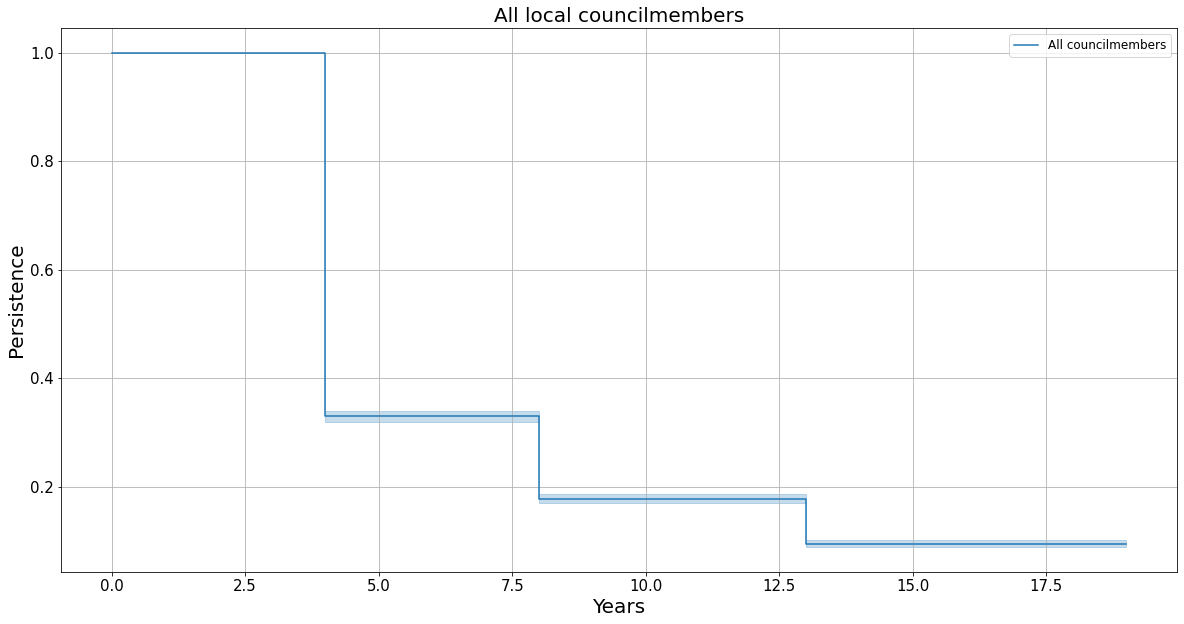

In [130]:
## Persistence of all elected councilmembers across parties
## Create Time and event for KaplanMeierFitter
Time = cand["Time"]
Event = cand["Event"]

## Plot subplot

ax = plt.subplot(111)

## Fit Time and Event variables to KaplanMeierFitter
kmf.fit(Time, event_observed=Event, label="All councilmembers", timeline=range(0,20,1))
kmf.plot(ax=ax)

## Calculate the median survival time
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

## Print out the median value
print("Median:",median_)


## Setting up the plot
ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('All local councilmembers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

## And finally save this for my blog entry

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_all_councilmembers.png')



Male median: 4.0
Female median: 4.0


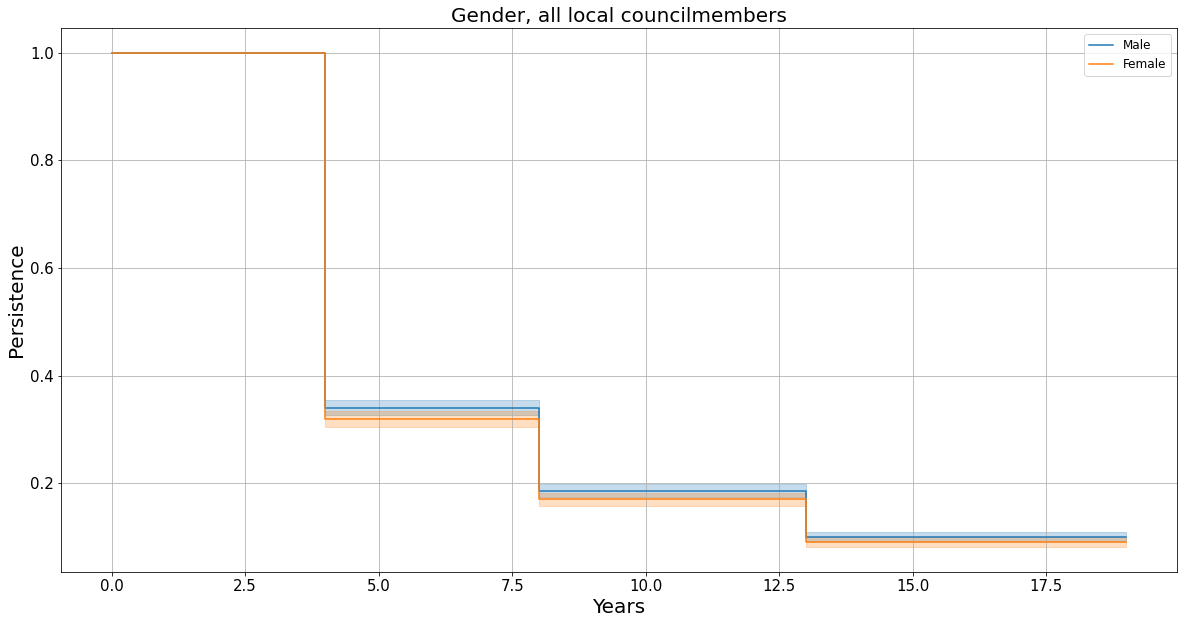

In [131]:
## Next I compare male and female persistence for all parties and all elected councilmembers

## Create Time and event for KaplanMeierFitter
Time = cand["Time"]
Event = cand["Event"]

## Plot subplot

ax = plt.subplot(111)

## Create variables for each value.
male = (cand["Gender"] == "Male")
female = (cand["Gender"] == "Female")

## Fit Time and Event variables to KaplanMeierFitter
kmf.fit(Time[male], event_observed=Event[male], label="Male", timeline=range(0,20,1))
kmf.plot(ax=ax)

## Calculate the median survival time
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

## Print out the median value
print("Male median:",median_)

## Repeat for females 
kmf.fit(Time[female], event_observed=Event[female], label="Female", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('Female median:',median_)

## Setting up the plot
ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('Gender, all local councilmembers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

## And finally save this for my blog entry

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_gender.png')


In [132]:
Time = cand["Time"]
Event = cand["Event"]
male = (cand["Gender"] == "Male")
female = (cand["Gender"] == "Female")
kmf.fit(Time[male], event_observed=Event[male])
kmf.survival_function_


,Female
timeline,
0.0,1.000000
4.0,0.340646
8.0,0.186355
13.0,0.100771
17.0,0.100771


In [133]:
Time = cand["Time"]
Event = cand["Event"]
male = (cand["Gender"] == "Male")
female = (cand["Gender"] == "Female")
kmf.fit(Time[female], event_observed=Event[female])
kmf.survival_function_



,Female
timeline,
0.0,1.000000
4.0,0.319775
8.0,0.170120
13.0,0.090049
17.0,0.090049


In [134]:
## Also check the mean values for both genders

print("Mean values, years, for genders:", cand.groupby(["Gender"])["Time"].mean())


Mean values, years, for genders: Gender
Female    6.489895
Male      6.697445
Name: Time, dtype: float64


Median persistence of local councilmembers for each party:
KD :  4.0  years
KESK :  4.0  years
KOK :  4.0  years
RKP :  4.0  years
SDP :  4.0  years
VAS :  4.0  years
VIHR :  4.0  years


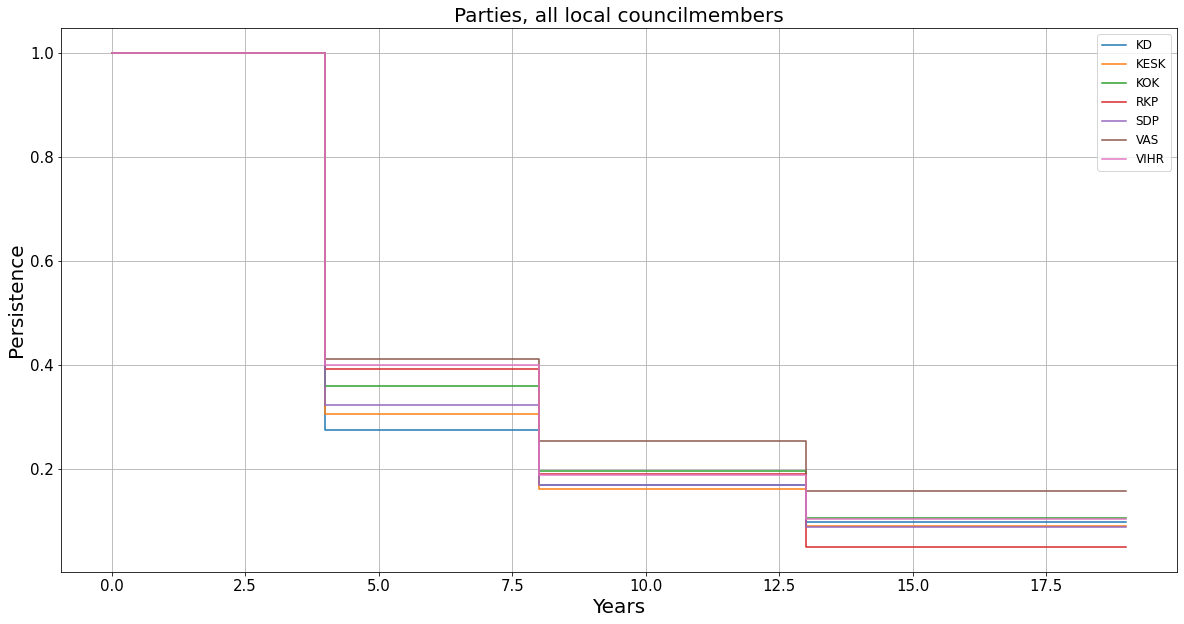

In [135]:

## Plot major parties

Time = cand_major["Time"]
Event = cand_major["Event"]

ax = plt.subplot(111)

print("Median persistence of local councilmembers for each party:")

## Another way to fit multiple parameters to KaplanMeierFitter
for party, grouped_df in cand_major.groupby("Party"):
    kmf.fit(grouped_df["Time"], grouped_df["Event"], label=party, timeline=range(0,20,1))
    kmf.plot(ax=ax, ci_show=False)
    median_ = kmf.median_survival_time_
    # median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(party, ": " ,median_, " years")


ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('Parties, all local councilmembers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

#€ Saves the figure as png

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_major_parties_new.png')



In [136]:
## Calculating means for parties and parties divided by gender

cand_mean = cand_major.groupby(["Party"])['Time'].mean().reset_index(name='Avg_Time')

cand_gender_mean = cand_major.groupby(["Party", "Gender"])['Time'].mean().reset_index(name='Avg_Time')

print(cand_mean)

print(cand_gender_mean)


  Party  Avg_Time
0    KD  6.324219
1  KESK  6.385102
2   KOK  6.831579
3   RKP  6.706897
4   SDP  6.486473
5   VAS  7.538931
6  VIHR  6.946939
   Party  Gender  Avg_Time
0     KD  Female  6.349650
1     KD    Male  6.292035
2   KESK  Female  6.165224
3   KESK    Male  6.582744
4    KOK  Female  6.876923
5    KOK    Male  6.791304
6    RKP  Female  6.610169
7    RKP    Male  6.807018
8    SDP  Female  6.460744
9    SDP    Male  6.511604
10   VAS  Female  7.187500
11   VAS    Male  7.814714
12  VIHR  Female  6.977528
13  VIHR    Male  6.865672


Next I will repeat the prior steps to freshmen local councilmembers

Male median: 4.0  years
Female median: 4.0  years


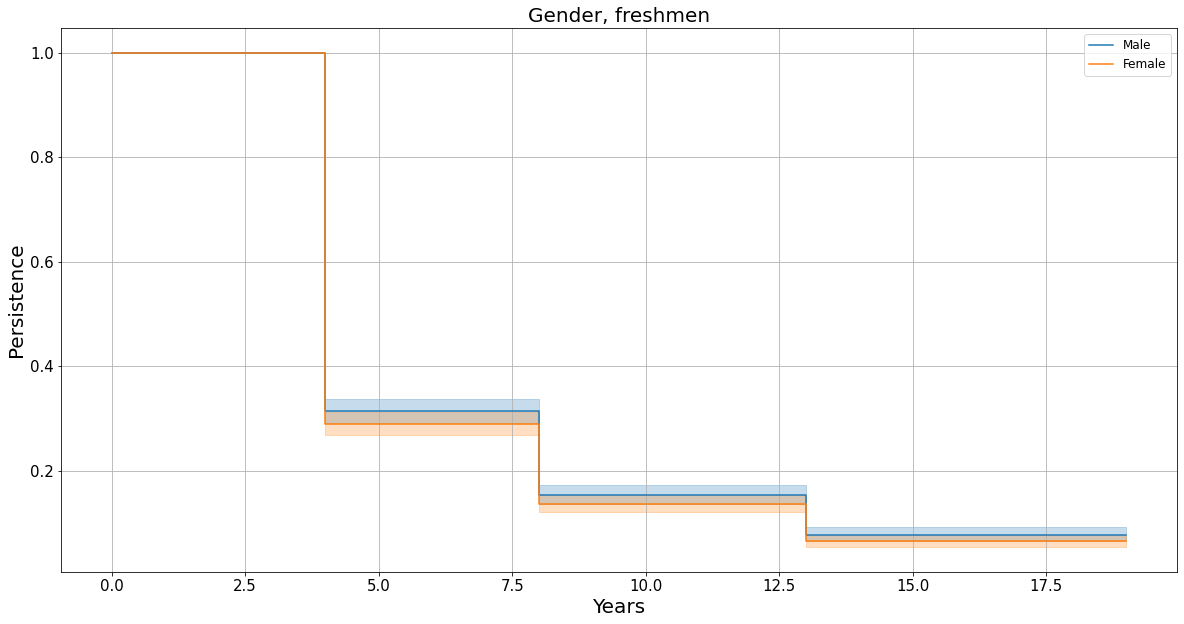

In [137]:
## Next I compare male and female persistence for all parties and all elected councilmembers

## Create Time and event for KaplanMeierFitter
Time = new_cand["Time"]
Event = new_cand["Event"]

## Plot subplot

ax = plt.subplot(111)

## Create variables for each value.
male = (new_cand["Gender"] == "Male")
female = (new_cand["Gender"] == "Female")

## Fit Time and Event variables to KaplanMeierFitter
kmf.fit(Time[male], event_observed=Event[male], label="Male", timeline=range(0,20,1))
kmf.plot(ax=ax)

## Calculate the median survival time
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

## Print out the median value
print("Male median:",median_, " years")

## Repeat for females 
kmf.fit(Time[female], event_observed=Event[female], label="Female", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print('Female median:',median_, " years")

## Setting up the plot
ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('Gender, freshmen', size = 20)
ax.legend(loc='upper right', fontsize = 12)

## And finally save this for my blog entry

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/freshmen_persistence_gender.png')



In [138]:
Time = new_cand["Time"]
Event = new_cand["Event"]
kmf.fit(Time[female], event_observed=Event[female], label="Female")
kmf.survival_function_

,Female
timeline,
0.0,1.000000
4.0,0.289965
8.0,0.137106
13.0,0.064761
17.0,0.064761


In [139]:
## Also check the mean values for both genders for the freshmen candidates

print("Mean values for genders:", new_cand.groupby(["Gender"])["Time"].mean())

Mean values for genders: Gender
Female    6.104434
Male      6.339735
Name: Time, dtype: float64


Median persistence of local councilmembers for each party:
KD :  4.0  years
KESK :  4.0  years
KOK :  4.0  years
RKP :  4.0  years
SDP :  4.0  years
VAS :  4.0  years
VIHR :  4.0  years


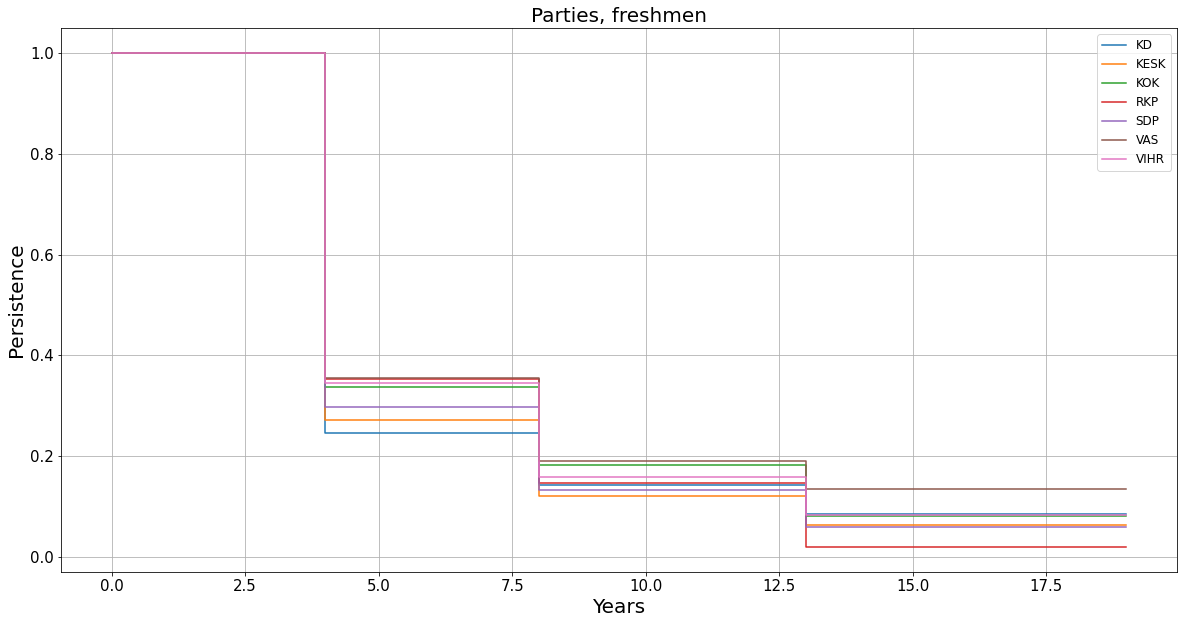

In [140]:

## Plot major parties for freshmen

Time = new_cand_major["Time"]
Event = new_cand_major["Event"]

ax = plt.subplot(111)

print("Median persistence of local councilmembers for each party:")

## Another way to fit multiple parameters to KaplanMeierFitter
for party, grouped_df in new_cand_major.groupby("Party"):
    kmf.fit(grouped_df["Time"], grouped_df["Event"], label=party, timeline=range(0,20,1))
    kmf.plot(ax=ax, ci_show=False)
    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(party, ": " ,median_, " years")


ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('Parties, freshmen', size = 20)
ax.legend(loc='upper right', fontsize = 12)

#€ Saves the figure as png

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/freshmen_persistence_major_parties.png')




In [141]:
## Calculating means for parties and parties divided by gender for the freshmen local councilmembers

new_cand_mean = new_cand_major.groupby(["Party"])['Time'].mean().reset_index(name='Avg_Time')

new_cand_gender_mean = new_cand_major.groupby(["Party", "Gender"])['Time'].mean().reset_index(name='Avg_Time')

print(new_cand_mean)

print(new_cand_gender_mean)



  Party  Avg_Time
0    KD  6.042373
1  KESK  5.950758
2   KOK  6.589744
3   RKP  6.226667
4   SDP  6.103164
5   VAS  6.907173
6  VIHR  6.512605
   Party  Gender  Avg_Time
0     KD  Female  5.893333
1     KD    Male  6.302326
2   KESK  Female  5.725806
3   KESK    Male  6.202811
4    KOK  Female  6.723077
5    KOK    Male  6.461538
6    RKP  Female  6.300000
7    RKP    Male  6.116667
8    SDP  Female  6.017949
9    SDP    Male  6.201780
10   VAS  Female  6.305085
11   VAS    Male  7.504202
12  VIHR  Female  6.579545
13  VIHR    Male  6.322581


Last I compare the freshmen versus sitting candidates persistence

             Fresh
timeline          
0.0       1.000000
4.0       0.301489
8.0       0.145161
13.0      0.070720
17.0      0.070720
             Fresh
timeline          
0.0       1.000000
4.0       0.349886
8.0       0.200703
13.0      0.112146
17.0      0.112146
Freshmen median: 4.0
Sitting median: 4.0


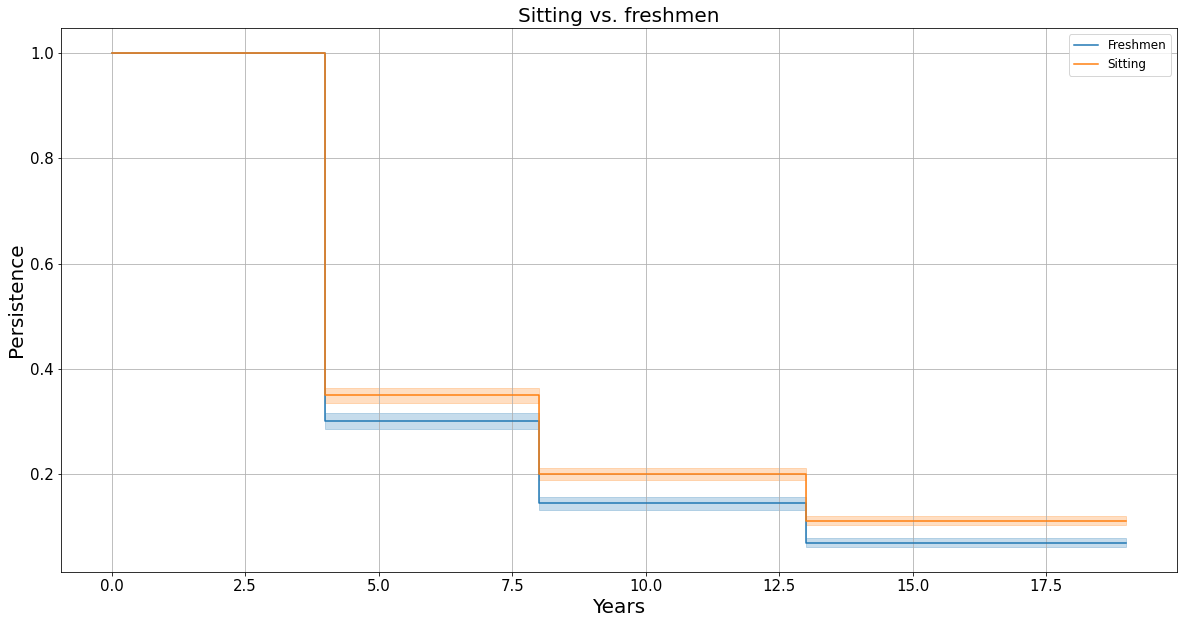

In [142]:
## Next I compare freshmen and old local councilmembers' persistence for all parties and all elected councilmembers

## Create Time and event for KaplanMeierFitter
Time = cand["Time"]
Event = cand["Event"]

## Plot subplot

ax = plt.subplot(111)

## Create variables for each value.
fresh = (cand["Sitting"] == 0)
old = (cand["Sitting"] == 1)

kmf.fit(Time[fresh], Event[fresh], label="Fresh")
print(kmf.survival_function_)

kmf.fit(Time[old], Event[old], label="Fresh")
print(kmf.survival_function_)

## Fit Time and Event variables to KaplanMeierFitter
kmf.fit(Time[fresh], event_observed=Event[fresh], label="Freshmen", timeline=range(0,20,1))
kmf.plot(ax=ax)

## Calculate the median survival time
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

## Print out the median value
print("Freshmen median:",median_)

## Repeat for females 
kmf.fit(Time[old], event_observed=Event[old], label="Sitting", timeline=range(0,20,1))
kmf.plot(ax=ax)
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("Sitting median:",median_)

## Setting up the plot
ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('Sitting vs. freshmen', size = 20)
ax.legend(loc='upper right', fontsize = 12)

## And finally save this for my blog entry

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_sitting_freshmen.png')



In [143]:
## Also check the mean values for both sitting and freshmen local councilmembers

print("1 for sitting elected, 0 for freshmen local councilmembers")
print("Mean values:", cand.groupby(["Sitting"])["Time"].mean())

1 for sitting elected, 0 for freshmen local councilmembers
Mean values: Sitting
0    6.214640
1    6.851645
Name: Time, dtype: float64


In [144]:
## Also check the mean values for both sitting and freshmen local councilmembers

print("1 for sitting elected, 0 for freshmen local councilmembers, major parties")
print("Mean values:", cand_major.groupby(["Sitting", "Party"])["Time"].mean())

1 for sitting elected, 0 for freshmen local councilmembers, major parties
Mean values: Sitting  Party
0        KD       6.042373
         KESK     5.950758
         KOK      6.589744
         RKP      6.226667
         SDP      6.103164
         VAS      6.907173
         VIHR     6.512605
1        KD       6.565217
         KESK     6.666667
         KOK      7.018670
         RKP      7.070707
         SDP      6.712662
         VAS      7.897129
         VIHR     7.357143
Name: Time, dtype: float64


In [145]:
## Also check the mean values for both sitting and freshmen local councilmembers grouping by gender

print("1 for sitting elected, 0 for freshmen local councilmembers, genders")
print("Mean values:", cand_major.groupby(["Sitting", "Gender"])["Time"].mean())

1 for sitting elected, 0 for freshmen local councilmembers, genders
Mean values: Sitting  Gender
0        Female    6.118613
         Male      6.374474
1        Female    6.840649
         Male      6.930855
Name: Time, dtype: float64


In [146]:
## Also check the mean values for both sitting and freshmen local councilmembers grouping by party and gender
import numpy as np
print("1 for sitting elected, 0 for freshmen local councilmembers, genders")
print("Mean values:", np.round(cand_major.groupby(["Sitting", "Party", "Gender"])["Time"].mean(), 1))

1 for sitting elected, 0 for freshmen local councilmembers, genders
Mean values: Sitting  Party  Gender
0        KD     Female    5.9
                Male      6.3
         KESK   Female    5.7
                Male      6.2
         KOK    Female    6.7
                Male      6.5
         RKP    Female    6.3
                Male      6.1
         SDP    Female    6.0
                Male      6.2
         VAS    Female    6.3
                Male      7.5
         VIHR   Female    6.6
                Male      6.3
1        KD     Female    6.9
                Male      6.3
         KESK   Female    6.5
                Male      6.8
         KOK    Female    7.0
                Male      7.0
         RKP    Female    6.9
                Male      7.2
         SDP    Female    6.8
                Male      6.7
         VAS    Female    7.8
                Male      8.0
         VIHR   Female    7.4
                Male      7.3
Name: Time, dtype: float64


In [147]:
## Here we create a smaller dataframe to contain only the largest parties
## https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition

## Using transform function I take into account only parties which had more than 200 elected councilmembers in 2004
## and create a new dataframe for the purpose
cand_large = cand[cand.groupby('Party').Party.transform('count')>400].copy()
new_cand_large = new_cand[new_cand.groupby('Party').Party.transform('count')>400].copy()

Median persistence of local councilmembers for each party:
KESK :  4.0  years
KOK :  4.0  years
SDP :  4.0  years
VAS :  4.0  years


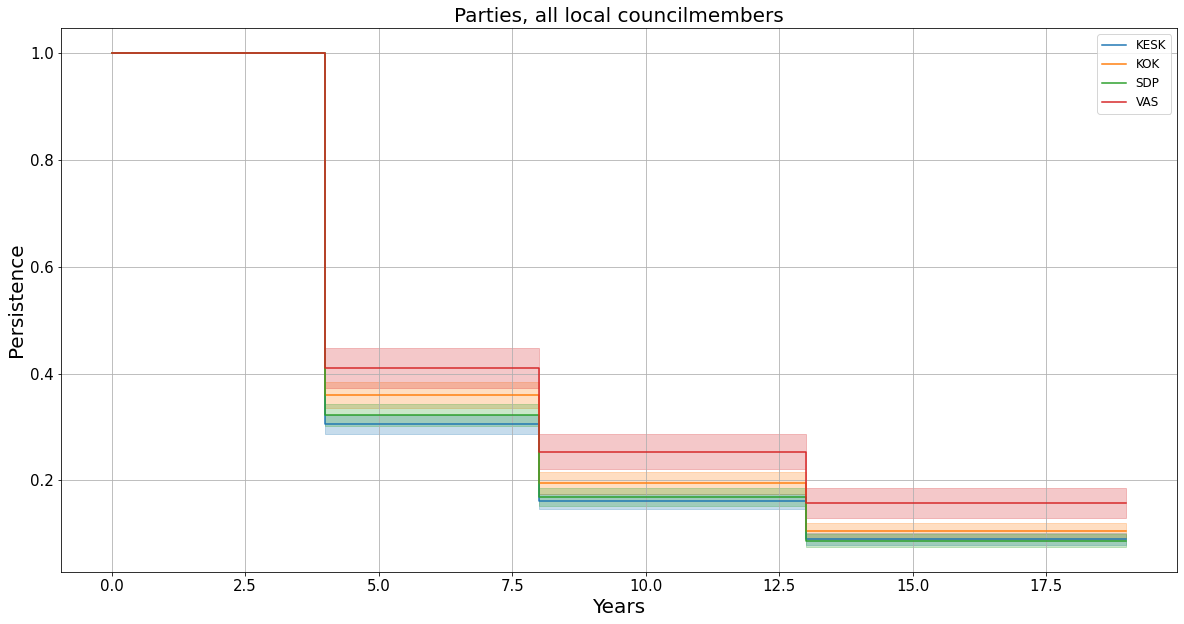

In [148]:

## Plot the largest parties

Time = cand_large["Time"]
Event = cand_large["Event"]

ax = plt.subplot(111)

print("Median persistence of local councilmembers for each party:")

## Another way to fit multiple parameters to KaplanMeierFitter
for party, grouped_df in cand_large.groupby("Party"):
    kmf.fit(grouped_df["Time"], grouped_df["Event"], label=party, timeline=range(0,20,1))
    kmf.plot(ax=ax)
    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(party, ": " ,median_, " years")


ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('Parties, all local councilmembers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

## Save the plot

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/persistence_largest_parties.png')




Median persistence of local councilmembers for each party:
KESK :  4.0  years
KOK :  4.0  years
SDP :  4.0  years


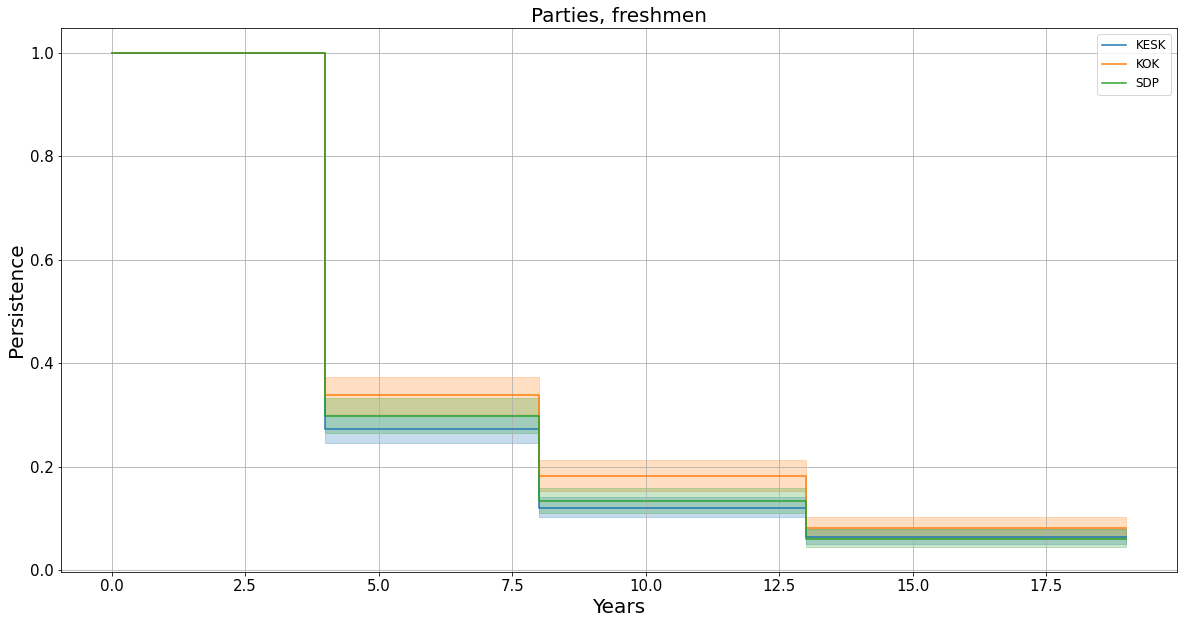

In [149]:

## Plot major parties for freshmen

Time = new_cand_large["Time"]
Event = new_cand_large["Event"]

ax = plt.subplot(111)

print("Median persistence of local councilmembers for each party:")

## Another way to fit multiple parameters to KaplanMeierFitter
for party, grouped_df in new_cand_large.groupby("Party"):
    kmf.fit(grouped_df["Time"], grouped_df["Event"], label=party, timeline=range(0,20,1))
    kmf.plot(ax=ax)
    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(party, ": " ,median_, " years")


ax.grid()
ax.set_xlabel('Years', size = 20)
ax.set_ylabel('Persistence', size = 20)
ax.set_title('Parties, freshmen', size = 20)
ax.legend(loc='upper right', fontsize = 12)

## Remember to save

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/freshmen_persistence_largest_parties.png')





In [150]:
## Compare persistence according to gender in the large parties
## First create two separate dataframes according to gender

cand_large_female = cand_large[cand_large.Gender == "Female"]

cand_large_male = cand_large[cand_large.Gender == "Male"]

new_cand_large_female = new_cand_large[new_cand_large.Gender == "Female"]

new_cand_large_male = new_cand_large[new_cand_large.Gender == "Male"]

               All
timeline          
0.0       1.000000
4.0       0.318014
8.0       0.170574
13.0      0.094078
17.0      0.094078
              KESK
timeline          
0.0       1.000000
4.0       0.286389
8.0       0.141621
13.0      0.077891
17.0      0.077891


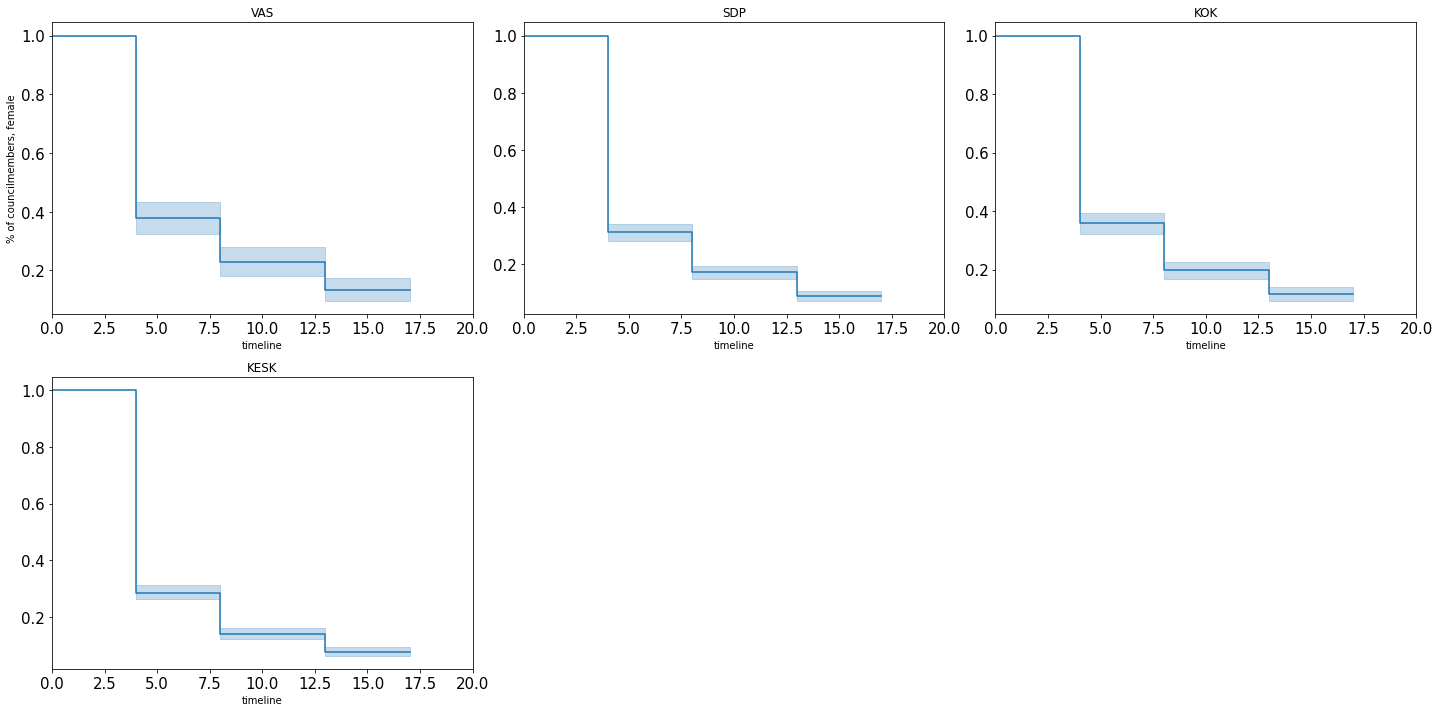

In [151]:
Time = cand_large_female["Time"]
Event = cand_large_female["Event"]


kmf.fit(Time, Event, label="All")
print(kmf.survival_function_)

parties = cand_large_female["Party"].unique()

for i, party in enumerate(parties):
    ax = plt.subplot(2, 3, i + 1)

    ix = cand_large_female["Party"] == party
    kmf.fit(Time[ix], Event[ix], label=party)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(party)
    plt.xlim(0, 20)

    if i==0:
        plt.ylabel("% of councilmembers, female")

plt.tight_layout()


plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/female_persistence_largest_parties.png')


print(kmf.survival_function_)

               All
timeline          
0.0       1.000000
4.0       0.345541
8.0       0.187867
13.0      0.103718
17.0      0.103718
              KESK
timeline          
0.0       1.000000
4.0       0.321782
8.0       0.178218
13.0      0.101132
17.0      0.101132


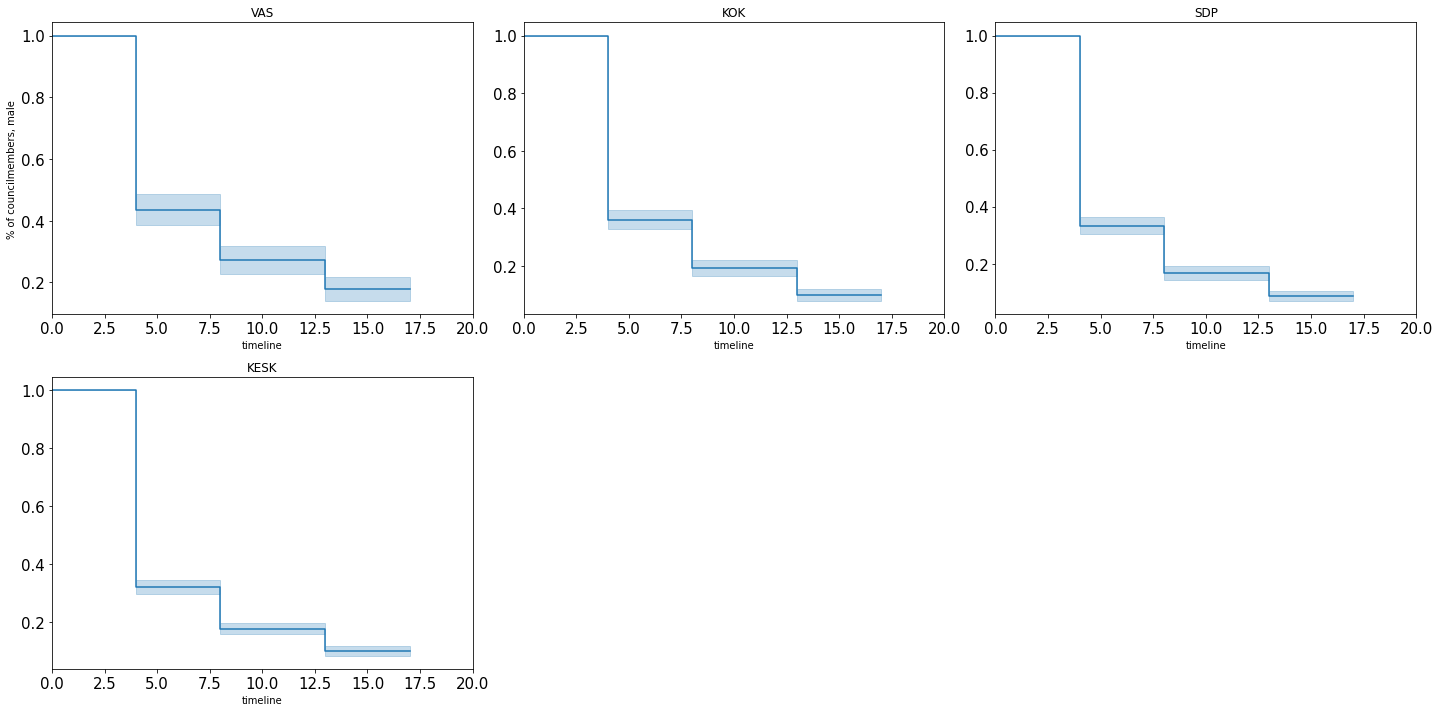

In [152]:
Time = cand_large_male["Time"]
Event = cand_large_male["Event"]


kmf.fit(Time, Event, label="All")
print(kmf.survival_function_)

parties = cand_large_male["Party"].unique()

for i, party in enumerate(parties):
    ax = plt.subplot(2, 3, i + 1)

    ix = cand_large_male["Party"] == party
    kmf.fit(Time[ix], Event[ix], label=party)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(party)
    plt.xlim(0, 20)

    if i==0:
        plt.ylabel("% of councilmembers, male")

plt.tight_layout()

plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/male_persistence_largest_parties.png')


print(kmf.survival_function_)

               All
timeline          
0.0       1.000000
4.0       0.284368
8.0       0.134328
13.0      0.065200
17.0      0.065200
              KESK
timeline          
0.0       1.000000
4.0       0.243728
8.0       0.105735
13.0      0.055556
17.0      0.055556


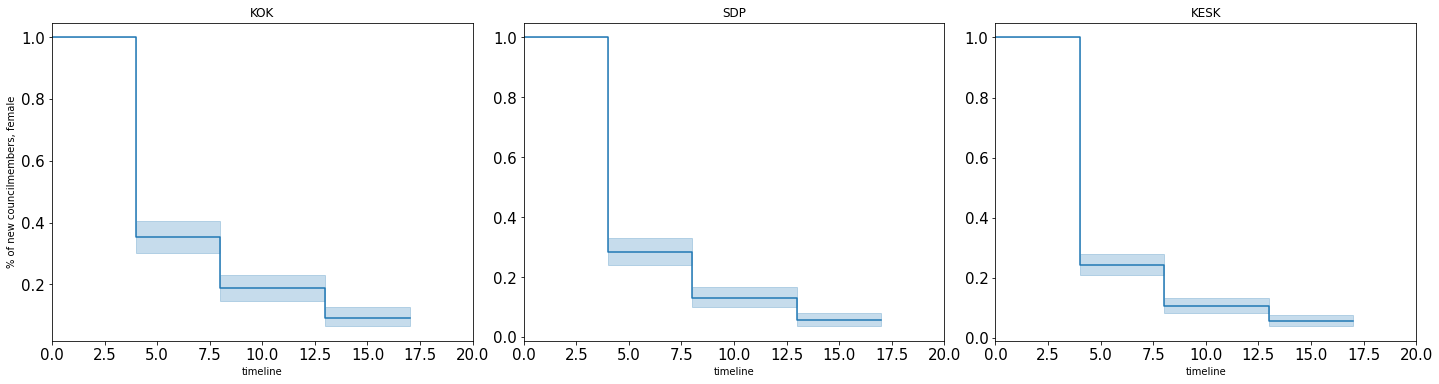

In [153]:
Time = new_cand_large_female["Time"]
Event = new_cand_large_female["Event"]



kmf.fit(Time, Event, label="All")
print(kmf.survival_function_)

parties = new_cand_large_female["Party"].unique()

for i, party in enumerate(parties):
    ax = plt.subplot(2, 3, i + 1)

    ix = new_cand_large_female["Party"] == party
    kmf.fit(Time[ix], Event[ix], label=party)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(party)
    plt.xlim(0, 20)

    if i==0:
        plt.ylabel("% of new councilmembers, female")

plt.tight_layout()


plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/female_freshmen_persistence_largest_parties.png')

print(kmf.survival_function_)


               All
timeline          
0.0       1.000000
4.0       0.312873
8.0       0.149190
13.0      0.069906
17.0      0.069906
              KESK
timeline          
0.0       1.000000
4.0       0.305221
8.0       0.138554
13.0      0.072289
17.0      0.072289


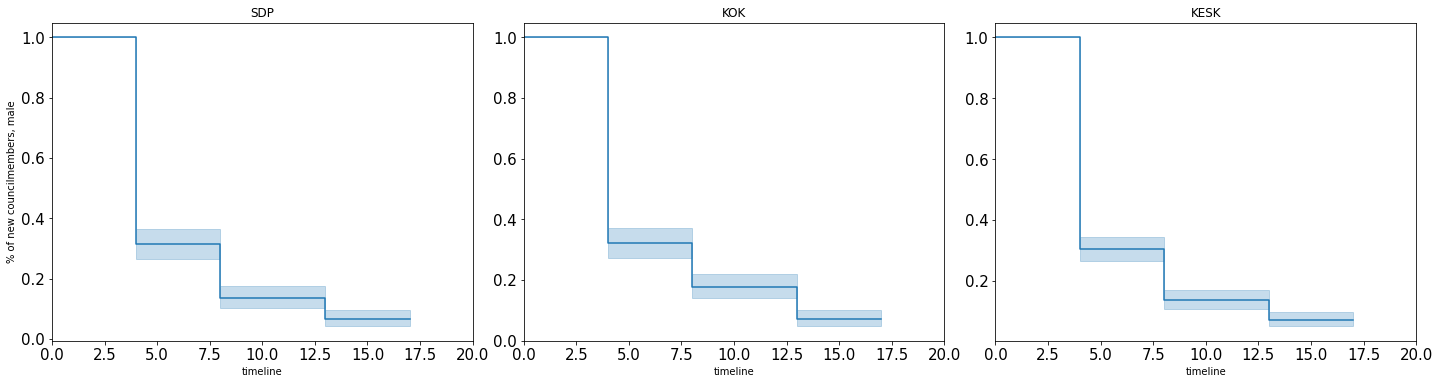

In [154]:
Time = new_cand_large_male["Time"]
Event = new_cand_large_male["Event"]

kmf.fit(Time, Event, label="All")
print(kmf.survival_function_)

parties = new_cand_large_male["Party"].unique()

for i, party in enumerate(parties):
    ax = plt.subplot(2, 3, i + 1)

    ix = new_cand_large_male["Party"] == party
    kmf.fit(Time[ix], Event[ix], label=party)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(party)
    plt.xlim(0, 20)

    if i==0:
        plt.ylabel("% of new councilmembers, male")

plt.tight_layout()


plt.savefig(r'/Users/johannesniemelainen/Documents/Python/PythonforDataScience/male_freshmen_persistence_largest_parties.png')


print(kmf.survival_function_)